# Lab 2: Portfolio Optimization

In this lab we will explore:
- How to compute the return of a portfolio of assets.
- How to compute the volatility of a portfolio of assets.
- How to optimize a portfolio.

## Imports

In this lab we use the following new packages:
- `cvxpy`: Used for convex optimization and quadratic programming.
- `numpy`: Useful for matrix opperations.
- `matplotlib`: Plotting library.
- `seaborn`: A wrapper for `matplotlib` that makes charting a little easier.

In [1]:
import sf_quant.data as sfd
import sf_quant.optimizer as sfo
import polars as pl
import datetime as dt
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/home/acriddl2/Projects/sf-quant-labs/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-09 21:09:17,614	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Data

Here we pull daily returns for Apple, Ford, Verizon, and Coke.

In [2]:
start = dt.date(2024, 1, 1)
end = dt.date(2024, 12, 31)

in_sample = [start, dt.date(2024, 5, 31)]
out_of_sample = [dt.date(2024, 6, 1), end]

columns = [
    'date',
    'barrid',
    'ticker',
    'return'
]

tickers = sorted(['AAPL', 'F', 'VZ', 'K'])

returns = (
        sfd.load_assets(
        start=start,
        end=end,
        in_universe=True,
        columns=columns
    )
    .filter(
        pl.col('ticker').is_in(tickers)
    )
    .with_columns(
        pl.col('return').truediv(100)
    )
)

returns

date,barrid,ticker,return
date,str,str,f64
2024-01-02,"""USAB1X1""","""AAPL""",-0.035787
2024-01-03,"""USAB1X1""","""AAPL""",-0.007488
2024-01-04,"""USAB1X1""","""AAPL""",-0.0127
2024-01-05,"""USAB1X1""","""AAPL""",-0.004013
2024-01-08,"""USAB1X1""","""AAPL""",0.024175
…,…,…,…
2024-12-24,"""USAHQN1""","""K""",0.001487
2024-12-26,"""USAHQN1""","""K""",0.003588
2024-12-27,"""USAHQN1""","""K""",0.00074


## Expected Returns Forecast

In practice we will forecast returns using a combination of signal forecasts, but for demonstration purposes we will just use the average historical returns as our expected returns forecast.

### Instructions
1. Create a expected returns vector for the `in_sample` period (it should be 1x4)

In [3]:
def expected_returns_task(returns: pl.DataFrame) -> np.array:
    """
    Compute the average daily return of each asset for the in_sample period.

    Args:
        returns (pl.DataFrame): a data frame containing date, ticker, and return columns

    Returns:
        np.array: a numpy array (1x4) with an entry for the average return of each ticker (sorted alphabetically by ticker)
    """

    returns = returns.clone()
    return returns.filter(pl.col("date") >= in_sample[0], pl.col("date") <= in_sample[1]).group_by("ticker").agg(pl.col("return").mean()).sort("ticker").select("return").to_numpy().flatten()
    

er_vector = expected_returns_task(returns)

er_vector

array([0.00011135, 0.00052617, 0.00092021, 0.0012419 ])

## Covariance Matrix Forecast

In practice we will use forecasted covariance matrices from Barra, but for demonstration purposes we will use the historical covariance matrix as our forecast.

### Instructions

1. Create the covariance matrix using returns from the `in_sample` period.

In [4]:
def covariance_matrix_task(returns: pl.DataFrame) -> np.array:
    """
    Compute the historical covariance matrix using the returns from the in_sample period.

    Args:
        returns (pl.DataFrame): a data frame containing date, ticker, and return columns

    Returns:
        np.array: a numpy array (4x4) containing the covariances of the assets (columns and rows are sorted alphabetically by ticker)
    """

    returns = returns.clone()
    return returns.filter(pl.col("date") >= in_sample[0], pl.col("date") <= in_sample[1]).sort("ticker").to_pandas().pivot(index="date", columns="ticker", values="return").cov().to_numpy()

cov_mat = covariance_matrix_task(returns)

cov_mat

array([[ 2.03265610e-04,  4.40064300e-05, -5.49098285e-06,
        -1.03171749e-05],
       [ 4.40064300e-05,  4.23402071e-04,  7.82493618e-05,
         4.68156080e-05],
       [-5.49098285e-06,  7.82493618e-05,  1.99415916e-04,
         4.00302177e-05],
       [-1.03171749e-05,  4.68156080e-05,  4.00302177e-05,
         1.88445492e-04]])

## Mean Variance Optimization

In order to determine how much of our portfolio to invest in each assset, we will use mean variance optimization to determine the maximum sharpe ratio portfolio.

### Instructions
1. Create the objective function for the `cp.Problem`

utility = portfolio_return - 0.5 * gamma * portfolio_variance

2. Constrain the problem such that
- Weights sum to 1 (full investment)
- Weights are greater than 0 (long only)
- Weights are less than 1 (no buying on margin)

3. Find the optimal portfolio weights by solving the `cp.Problem`

In [5]:
def optimization_task(tickers: list[str], er_vector: np.array, cov_mat: np.array) -> pl.DataFrame:
    """
    Compute the optimal weights of the portfolio given the expected returns forecast and the covariance matrix forecast.

    Args:
        ticker (list[str]): a list of tickers sorted alphabetically
        er_vector (np.array): a numpy array (1x4) with an entry for the average return of each ticker (sorted alphabetically by ticker)
        cov_mat (np.array): a numpy array (4x4) containing the covariances of the assets (columns and rows are sorted alphabetically by ticker)

    Returns:
        pl.DataFrame: a data frame with columns ticker and weight
    """
    portfolio = cp.Variable(len(tickers))
    gamma = 10
    
    objective = cp.Maximize(portfolio @ er_vector - .5 * gamma * cp.quad_form(portfolio, cov_mat))
    problem = cp.Problem(objective, [portfolio >= 0, cp.sum(portfolio) == 1, portfolio <= 1])
    problem.solve()
    return pl.DataFrame({"ticker": tickers, "weight": portfolio.value})

weights = optimization_task(tickers, er_vector, cov_mat)

print(weights)

shape: (4, 2)
┌────────┬─────────────┐
│ ticker ┆ weight      │
│ ---    ┆ ---         │
│ str    ┆ f64         │
╞════════╪═════════════╡
│ AAPL   ┆ 0.082826    │
│ F      ┆ -8.5171e-24 │
│ K      ┆ 0.336433    │
│ VZ     ┆ 0.580741    │
└────────┴─────────────┘


## In Sample vs. Out of Sample Performance

Now that we've identified the optimal weights let's see if our optimized portfolio outperforms a simple equal weighted portfolio.

### Instructions
1. Compute the baseline returns for the `out_of_sample` period by computing the equal weight returns for each period.
2. Compute the optimized returns for the `out_of_sample` period by computing the weighted return of the portfolio for each period using our optimal weights.
3. Plot the cumulative returns of each strategy in one chart.
4. Compute the total return, average daily return (annualized), volatility (annualized), and sharpe ratio (annualized) for both strategies.
5. Go back and try a handful of different `gamma` values in your optimizer and see how your performance results change.
6. Write a few sentences commenting on the results.

In [6]:
def baseline_returns_task(returns: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the average daily return of each asset for the out_of_sample period.

    Args:
        returns (pl.DataFrame): a data frame containing date, ticker, and return columns

    Returns:
        pl.DataFrame: a data frame containing date, return, and cumulative_return columns
    """

    returns = returns.clone()
    returns = pl.DataFrame({"date": returns.get_column("date").unique().sort(), "return": returns.pivot("ticker", index="date", values="return").select(tickers).mean_horizontal()}).filter(pl.col("date") >= out_of_sample[0], pl.col("date") <= out_of_sample[1]) 
    return returns.with_columns(((pl.col("return") + 1).cum_prod() - 1).alias("cumulative_return"))

baseline_returns = baseline_returns_task(returns)
baseline_returns

date,return,cumulative_return
date,f64,f64
2024-06-03,0.002974,0.002974
2024-06-04,0.003132,0.006115
2024-06-05,-0.001288,0.00482
2024-06-06,-0.000683,0.004134
2024-06-07,0.000482,0.004618
…,…,…
2024-12-24,0.005395,0.139042
2024-12-26,0.0039435,0.143534
2024-12-27,-0.004369,0.138538


In [7]:
def optimized_returns_task(returns: pl.DataFrame, weights: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the average daily return of each asset for the out_of_sample period.

    Args:
        returns (pl.DataFrame): a data frame containing date, ticker, and return columns
        weights (pl.DataFrame): a data frame with columns ticker and weight

    Returns:
        pl.DataFrame: a data frame containing date, return, and cumulative_return columns
    """

    returns = returns.clone()
    returns = returns.join(weights.clone(), on="ticker")
    returns = returns.with_columns((pl.col("return") * pl.col("weight")).alias("return"))
    returns = pl.DataFrame({"date": returns.get_column("date").unique().sort(), "return": returns.pivot("ticker", index="date", values="return").select(tickers).sum_horizontal()}).filter(pl.col("date") >= out_of_sample[0], pl.col("date") <= out_of_sample[1]) 
    return returns.with_columns(((pl.col("return") + 1).cum_prod() - 1).alias("cumulative_return"))

optimized_returns = optimized_returns_task(returns, weights)

optimized_returns

date,return,cumulative_return
date,f64,f64
2024-06-03,-0.001019,-0.001019
2024-06-04,0.01167,0.010639
2024-06-05,-0.006069,0.004505
2024-06-06,0.000762,0.005271
2024-06-07,-0.007029,-0.001795
…,…,…
2024-12-24,-0.000585,0.148875
2024-12-26,0.003805,0.153247
2024-12-27,-0.001429,0.151599


Text(0.5, 1.0, 'Performance of 4-Asset Portfolios')

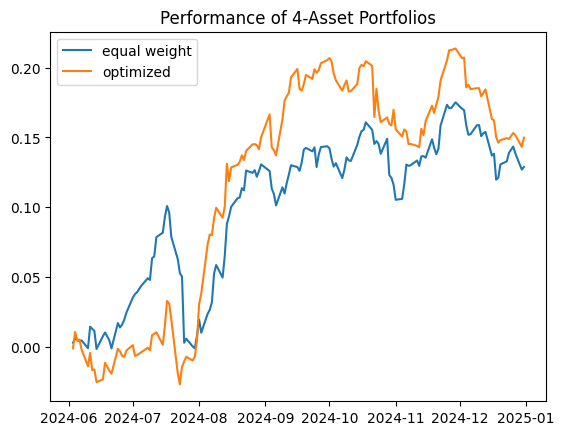

In [8]:
plt.plot(baseline_returns.get_column("date"), baseline_returns.get_column("cumulative_return"), label="equal weight")
plt.plot(optimized_returns.get_column("date"), optimized_returns.get_column("cumulative_return"), label="optimized")
plt.legend()
plt.title("Performance of 4-Asset Portfolios")

In [9]:
# TODO: Compute the total_return, average_return, volatility, and sharpe for the baseline and optimized strategies
print("Equal weight:")
total_return = baseline_returns.get_column("cumulative_return")[-1]
print("   Total return: " + str(total_return))
average_return = baseline_returns.get_column("return").mean()
print("   Average return: " + str(average_return))
volatility = baseline_returns.get_column("return").std()
print("   Volatility: " + str(volatility))
print("   Sharpe: " + str(average_return * np.sqrt(252/len(baseline_returns.get_column("return")))/volatility))
print()
print("Optimized:")
total_return = optimized_returns.get_column("cumulative_return")[-1]
print("   Total return: " + str(total_return))
average_return = optimized_returns.get_column("return").mean()
print("   Average return: " + str(average_return))
volatility = optimized_returns.get_column("return").std()
print("   Volatility: " + str(volatility))
print("   Sharpe: " + str(average_return * np.sqrt(252/len(optimized_returns.get_column("return")))/volatility))

Equal weight:
   Total return: 0.12887665031590667
   Average return: 0.0008601105442176873
   Volatility: 0.00838687818587667
   Sharpe: 0.1342751170357883

Optimized:
   Total return: 0.1498861430635321
   Average return: 0.0009932455421710524
   Volatility: 0.009272055050136561
   Sharpe: 0.14025625097793992


Comment here on the results that you have found.

The optimized portfolio performs marginally better than the equal-weighted. Granted, we never perform rebalancing, and as such we most likely lose out on some of the potential return. Notably, the optimized has a higher total return and a slightly higher volatility than the equal weight.

## `sf-quant` Optimizer Module

What if I told you that you don't have to write out the optimization code by hand again? Wouldn't that be great? Lucky for you we've pre-built a module in the `sf-quant` package that provides abstracted functionality for portfolio optimization.

### Instructions

- Create a `list` of constraints including `FullInvestment`, `LongOnly`, and `NoBuyingOnMargin`.
- Get the weights from the `sf_quant.optimizer.mve_optimizer` function using your previously computed returns forecast and covariance matrix.

Note: you should get really similar weights to your previous results.

In [10]:
def task_sf_optimizer_weights(tickers: list[str], er_vector: np.ndarray, cov_mat: np.ndarray) -> pl.DataFrame:
    """
    Compute the optimal weights of the portfolio given the expected returns forecast and the covariance matrix forecast.
    Make sure to use the sf_quant package.

    Args:
        ticker (list[str]): a list of tickers sorted alphabetically
        er_vector (np.array): a numpy array (1x4) with an entry for the average return of each ticker (sorted alphabetically by ticker)
        cov_mat (np.array): a numpy array (4x4) containing the covariances of the assets (columns and rows are sorted alphabetically by ticker)

    Returns:
        pl.DataFrame: a data frame with columns ticker and weight
    """
    print(cov_mat)
    print(er_vector)
    return sfo.mve_optimizer(tickers, er_vector, cov_mat, [sfo.FullInvestment(), sfo.LongOnly(), sfo.NoBuyingOnMargin()], gamma=10).rename({"barrid":"ticker"})

weights_sf = task_sf_optimizer_weights(tickers, er_vector, cov_mat)

weights_sf

[[ 2.03265610e-04  4.40064300e-05 -5.49098285e-06 -1.03171749e-05]
 [ 4.40064300e-05  4.23402071e-04  7.82493618e-05  4.68156080e-05]
 [-5.49098285e-06  7.82493618e-05  1.99415916e-04  4.00302177e-05]
 [-1.03171749e-05  4.68156080e-05  4.00302177e-05  1.88445492e-04]]
[0.00011135 0.00052617 0.00092021 0.0012419 ]


ticker,weight
str,f64
"""AAPL""",0.082826
"""F""",-1.8068e-23
"""K""",0.336433
"""VZ""",0.580741


## Barra Covariance Matrix

Now let's improve our portfolio by using a better forecast for the covariance matrix. We are very fortunate to have access to the MSCI Barra covariance matrix forecasts. In this task you will load the Barra covariance matrix for the last day of your in sample period and compute the new optimal weights.

### Instructions

- Use the `sf_quant.data.construct_covariance_matrix` function to pull the covariance matrix for the last market date of the in sample period.
- Compute the optimal weights of your portfolio using this new covariance matrix.
- Hint: since the Barra covariance matrix is annualized, you will need to multiply your returns forecast by 252.

In [11]:
def task_barra_optimizer_weights(returns: pl.DataFrame) -> pl.DataFrame:
    """ 
    Compute the optimal weights of the portfolio given the expected returns forecast and the barra covariance matrix forecast.
    Make sure to use the sf_quant package.

    Args:
        returns (pl.DataFrame): a data frame containing date, ticker, and return columns

    Returns:
        pl.DataFrame: a data frame with columns barrid and weight
    """
    
    cov_mat = sfd.construct_covariance_matrix(in_sample[1], returns.sort("ticker").get_column("barrid").unique(maintain_order=True)).to_numpy()[:,1:] / 252
    er_vector = expected_returns_task(returns)
    return task_sf_optimizer_weights(returns.get_column("ticker").unique().sort(), er_vector, cov_mat)

weights_barra = task_barra_optimizer_weights(returns)

weights_barra

[[0.000268660332697614 3.503865589173758e-05 0.00014045252137216203
  2.535366672319498e-05]
 [3.503865589173761e-05 0.00034805442414104427 9.79003416856002e-05
  5.340321683919041e-05]
 [0.00014045252137216197 9.790034168560016e-05 0.0004670571811365766
  6.21706917258006e-05]
 [2.5353666723194963e-05 5.3403216839190406e-05 6.217069172580064e-05
  0.0001537967063691507]]
[0.00011135 0.00052617 0.00092021 0.0012419 ]


ticker,weight
str,f64
"""AAPL""",7.2572e-14
"""F""",0.035
"""K""",0.110155
"""VZ""",0.854845


## Performance Analysis

Now that we've got the Barra optimal weights, let's see how they perform compared to our out of sample baseline.

### Instructions
1. Compute the optimized barra returns for the `out_of_sample` period by computing the weighted return of the portfolio for each period using our optimal weights.
2. Plot the cumulative returns of each strategy in one chart.
3. Compute the total return, average daily return (annualized), volatility (annualized), and sharpe ratio (annualized) for both strategies.
4. Go back and try a handful of different `gamma` values in your optimizer and see how your performance results change.
5. Write a few sentences commenting on the results.

In [12]:
def optimized_barra_returns_task(returns: pl.DataFrame, weights_barra: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the average daily return of each asset for the out_of_sample period.

    Args:
        returns (pl.DataFrame): a data frame containing date, ticker, and return columns
        weights_barra (pl.DataFrame): a data frame with columns ticker and weight

    Returns:
        pl.DataFrame: a data frame containing date, return, and cumulative_return columns
    """
    return optimized_returns_task(returns, weights_barra)

optimized_returns_barra = optimized_barra_returns_task(returns, weights_barra)

optimized_returns_barra

date,return,cumulative_return
date,f64,f64
2024-06-03,-0.003157,-0.003157
2024-06-04,0.012724,0.009527
2024-06-05,-0.005442,0.004033
2024-06-06,0.00012,0.004154
2024-06-07,-0.008678,-0.004559
…,…,…
2024-12-24,-0.002408,0.033247
2024-12-26,0.004006,0.037386
2024-12-27,-0.000913,0.036439


Text(0.5, 1.0, 'Performance of 4-Asset Portfolios')

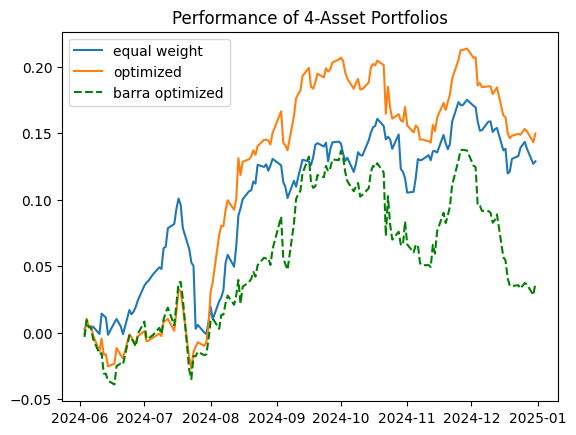

In [13]:
plt.plot(baseline_returns.get_column("date"), baseline_returns.get_column("cumulative_return"), label="equal weight")
plt.plot(optimized_returns.get_column("date"), optimized_returns.get_column("cumulative_return"), label="optimized")
plt.plot(optimized_returns_barra.get_column("date"), optimized_returns_barra.get_column("cumulative_return"), "g--", label="barra optimized")
plt.legend()
plt.title("Performance of 4-Asset Portfolios")

In [14]:
# TODO: Compute the total_return, average_return, volatility, and sharpe for the baseline and optimized strategies
print("Equal weight:")
total_return = baseline_returns.get_column("cumulative_return")[-1]
print("   Total return: " + str(total_return))
average_return = baseline_returns.get_column("return").mean()
print("   Average return: " + str(average_return))
volatility = baseline_returns.get_column("return").std()
print("   Volatility: " + str(volatility))
print("   Sharpe: " + str(average_return * np.sqrt(252/len(baseline_returns.get_column("return")))/volatility))
print()
print("Barra Optimized:")
total_return = optimized_returns_barra.get_column("cumulative_return")[-1]
print("   Total return: " + str(total_return))
average_return = optimized_returns_barra.get_column("return").mean()
print("   Average return: " + str(average_return))
volatility = optimized_returns_barra.get_column("return").std()
print("   Volatility: " + str(volatility))
print("   Sharpe: " + str(average_return * np.sqrt(252/len(optimized_returns_barra.get_column("return")))/volatility))

Equal weight:
   Total return: 0.12887665031590667
   Average return: 0.0008601105442176873
   Volatility: 0.00838687818587667
   Sharpe: 0.1342751170357883

Barra Optimized:
   Total return: 0.03724193071777804
   Average return: 0.00031381065159476114
   Volatility: 0.011403225657287734
   Sharpe: 0.036031435516226715


Comment here on the results that you have found.

Here we see that the Barra optimized portfolio performs significantly worse than our previous optimized and equal weight portfolios. The Sharpe rate is considerably smaller, with a much higher volatility and much lower return. The best explanation for this seems to be that the Barra historical covariance matrix probably doesn't accurately reflect the ongoing market conditions.